## Imports

In [3]:
import logging
import warnings
import re
import os
import re
import yaml
import json
import joblib
import time
import numpy as np
import pandas as pd
from typing import Any, Dict, Iterable, List, Tuple
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.lib.io import file_io
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.python.lib.io import file_io
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    cohen_kappa_score,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
)

warnings.filterwarnings("ignore")

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
AUTO = tf.data.experimental.AUTOTUNE

In [2]:
!pip install transformers

  Using cached transformers-4.44.2-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-0.25.1-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.4.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.44.2-py3-none-any.whl (9.5 MB)
Using cached huggingface_hub-0.25.1-py3-none-any.whl (436 kB)
Using cached safetensors-0.4.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (435 kB)
Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)


## Utils

In [4]:
def read_json_file(data_path: str) -> pd.DataFrame:
    """
    This function read .log file into a CSV file
    """
    for filename in os.listdir(data_path):
        if filename.endswith(".log"):
            filepath = os.path.join(data_path, filename)
            data = pd.read_json(filepath, lines=True)
    return data

In [5]:
FEATURE_COLUMN_NAME = "clean_text"
LABEL_COLUMN_NAME = "category"
TITLE = "title"
QUERY = "query"
MAX_LENGTH = "max_length"
DATA = "data"
VAL_SIZE = "val_size"
RANDOM_STATE = "random_state"
TRANSFORMERS = "transformers"
TOKENIZER = "tokenizer"
ENCODING = "encoding"
TRAIN = "train"
BATCH_SIZE = "batch_size"
MODEL = "model"
OPTIMIZATION = "optimization"
INIT_LR = "init_lr"
CALLBACKS = "callbacks"
VERBOSE = "verbose"
VAL_LOSS = "val_loss"
REDUCE_ON_PLATEAU = "reduce_on_plateau"
PATIENCE = "patience"
MIN_LR = "min_lr"
MIN_DELTA = "min_delta"
METRICS_FULL_REPORT = "full_report"
MATHEW = "Mathew"
FACTOR = "factor"
EPOCHS = "epochs"
EARLY_STOPPING = "early_stopping"
COHEN = "Cohen"
ACTIVATION = "activation"
ACCURACY = "Accuracy"
INPUT_IDS = "input_ids"
ENCODED_LABEL = "encoded_label"
LABEL_ENCODER_PKL = "label_encoder.pkl"
METRICS_JSON = "metrics.json"
PREDICTED_CATEGORY = "predicted_catagory"
METRICS_DIR = "metrics"
INFERENCE = "inference"
PROB_SCORES = "prediction_probability"
FILE_NAME_PREFIX = "search_data_prediction_file"


In [6]:
file = read_json_file("data/raw_data")

In [7]:
file.head()

,session,name,query,title,product_id,category
0,b9705ccb2af11a0ed9201a7505520b946047caa4a7ffea...,search,blue dress,NaN,NaN,NaN
1,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,search,louis vuitton bag,NaN,NaN,NaN
2,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,productview,NaN,white prada bag,2089482.0,bags
3,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,productview,NaN,white leather bag,3909061.0,bags
4,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,productview,NaN,leather bag,6747521.0,bags


## EDA

In [8]:
print(f"Length of the file: {len(file)}")

Length of the file: 25909


In [9]:
print(f"How many rows are empty in the category column: {file['category'].isna().sum()}")

How many rows are empty in the category column: 9949


In [10]:
""" search query"""
file.loc[(file.name == "search")]

,session,name,query,title,product_id,category
0,b9705ccb2af11a0ed9201a7505520b946047caa4a7ffea...,search,blue dress,NaN,NaN,NaN
1,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,search,louis vuitton bag,NaN,NaN,NaN
5,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,search,blue metalic coat,NaN,NaN,NaN
8,04887a80950be6087da8b1e0ec3b80e8478db27779ce42...,search,ana luisa watch,NaN,NaN,NaN
10,04887a80950be6087da8b1e0ec3b80e8478db27779ce42...,search,gold calvin klein dress,NaN,NaN,NaN
...,...,...,...,...,...,...
25897,898713e12499b75ef0923dfbca592e461fd7768948727c...,search,gold calvin klein trousers,NaN,NaN,NaN
25900,cb584bd4e85ff229d07747e9564bb83c32ca210c8cb16d...,search,watch,NaN,NaN,NaN
25903,cb584bd4e85ff229d07747e9564bb83c32ca210c8cb16d...,search,metalic jeans,NaN,NaN,NaN
25904,6cf6d23ef44e96abb1631f784dff31c5cedecf986f77dc...,search,metalic bag,NaN,NaN,NaN


In [11]:
""" search where titile is null"""
file.loc[(file["name"] == "search") & (pd.isna(file["title"]))]

,session,name,query,title,product_id,category
0,b9705ccb2af11a0ed9201a7505520b946047caa4a7ffea...,search,blue dress,NaN,NaN,NaN
1,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,search,louis vuitton bag,NaN,NaN,NaN
5,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,search,blue metalic coat,NaN,NaN,NaN
8,04887a80950be6087da8b1e0ec3b80e8478db27779ce42...,search,ana luisa watch,NaN,NaN,NaN
10,04887a80950be6087da8b1e0ec3b80e8478db27779ce42...,search,gold calvin klein dress,NaN,NaN,NaN
...,...,...,...,...,...,...
25897,898713e12499b75ef0923dfbca592e461fd7768948727c...,search,gold calvin klein trousers,NaN,NaN,NaN
25900,cb584bd4e85ff229d07747e9564bb83c32ca210c8cb16d...,search,watch,NaN,NaN,NaN
25903,cb584bd4e85ff229d07747e9564bb83c32ca210c8cb16d...,search,metalic jeans,NaN,NaN,NaN
25904,6cf6d23ef44e96abb1631f784dff31c5cedecf986f77dc...,search,metalic bag,NaN,NaN,NaN


In [12]:
""" search where title is not null"""

file.loc[(file["name"] == "search") & (pd.notna(file["title"]))]

,session,name,query,title,product_id,category


In [13]:
serch_query = file.loc[file["name"]=="search"]

In [15]:
serch_query.head()

,session,name,query,title,product_id,category
0,b9705ccb2af11a0ed9201a7505520b946047caa4a7ffea...,search,blue dress,NaN,NaN,NaN
1,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,search,louis vuitton bag,NaN,NaN,NaN
5,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,search,blue metalic coat,NaN,NaN,NaN
8,04887a80950be6087da8b1e0ec3b80e8478db27779ce42...,search,ana luisa watch,NaN,NaN,NaN
10,04887a80950be6087da8b1e0ec3b80e8478db27779ce42...,search,gold calvin klein dress,NaN,NaN,NaN


In [16]:
productview_data = file.loc[file["name"]=="productview"]

In [17]:
productview_data.head()

,session,name,query,title,product_id,category
2,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,productview,NaN,white prada bag,2089482.0,bags
3,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,productview,NaN,white leather bag,3909061.0,bags
4,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,productview,NaN,leather bag,6747521.0,bags
6,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,productview,NaN,red gucci coat,7366850.0,coats
7,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,productview,NaN,coat,1255264.0,coats


In [48]:
set(productview_data.category)

{'bags', 'coats', 'dresses', 'jewellery', 'pants', 'shoes', 'watches'}

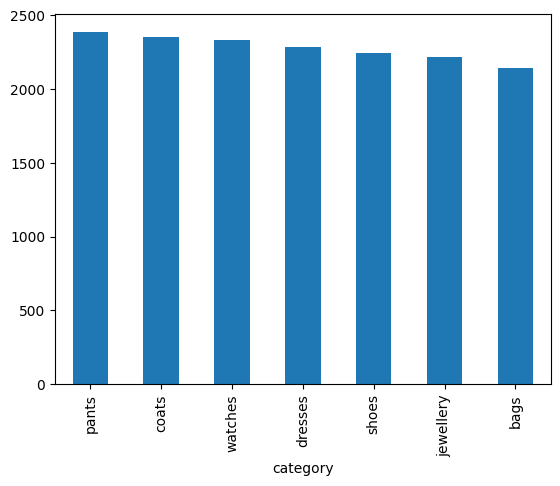

In [18]:
productview_data["category"].value_counts().plot.bar();

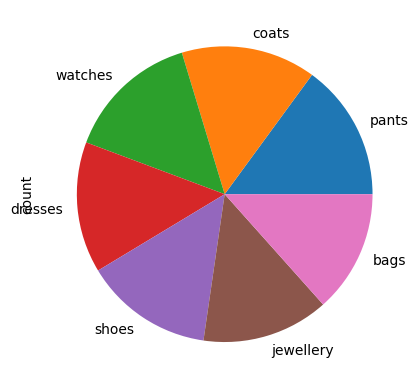

In [19]:
productview_data["category"].value_counts().plot.pie();

In [20]:
len(productview_data["category"].unique())

7

In [21]:
perc = len(productview_data["title"].apply(lambda x: str(x).casefold().strip()).unique()) / len(
    productview_data
)
print(f"The percentage of the unique title is {round(perc*100, 1)}%")

The percentage of the unique title is 15.7%


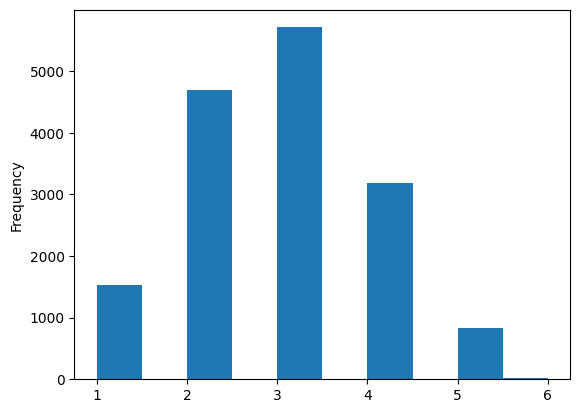

In [22]:
nwords = productview_data["title"].apply(lambda x: len(str(x).split()))
nwords.plot.hist();

In [23]:
productview_data.loc[productview_data.title.duplicated()]

,session,name,query,title,product_id,category
109,6f4e7bb1c7ab3061f1599a6960eb7ac8ad90a86f5b3d11...,productview,NaN,gold hermes bag,4902889.0,bags
121,3366fda915618545d6cb8d0c29d6faefa573816969a09f...,productview,NaN,calvin klein trousers,9085747.0,pants
164,2856892d651bf337015d3251b1cebb832f67821b86050d...,productview,NaN,hermes bag,9013614.0,bags
177,c28ecb5bfd55299127174da4e38c5bcaf0453379c5f915...,productview,NaN,wristwatch,669121.0,jewellery
179,c28ecb5bfd55299127174da4e38c5bcaf0453379c5f915...,productview,NaN,calvin klein clothing,8570802.0,dresses
...,...,...,...,...,...,...
25901,cb584bd4e85ff229d07747e9564bb83c32ca210c8cb16d...,productview,NaN,ana luisa watch,4591253.0,jewellery
25902,cb584bd4e85ff229d07747e9564bb83c32ca210c8cb16d...,productview,NaN,gucci watch,8384666.0,jewellery
25905,6cf6d23ef44e96abb1631f784dff31c5cedecf986f77dc...,productview,NaN,black gold handbag,8869782.0,bags
25906,6cf6d23ef44e96abb1631f784dff31c5cedecf986f77dc...,productview,NaN,blue wool hermes handbag,1227723.0,bags


In [24]:
productview_data.loc[productview_data.category=="jewellery"]

,session,name,query,title,product_id,category
9,04887a80950be6087da8b1e0ec3b80e8478db27779ce42...,productview,NaN,beige metalic ana luisa watch,8882812.0,jewellery
17,8bb909f2e71d211b11ec82988eefe0c06669d4c9e100b9...,productview,NaN,black gold gucci wristwatch,74491.0,jewellery
18,8bb909f2e71d211b11ec82988eefe0c06669d4c9e100b9...,productview,NaN,metalic wristwatch,1244247.0,jewellery
29,7039fd0ea22577b570990052cb96e99d5fc03736cf40ad...,productview,NaN,gold watch,3354668.0,jewellery
82,2c066bd6d431d59cbdb8ccf1b240982dd0e3cdaf31e1b7...,productview,NaN,gucci wristwatch,7224256.0,jewellery
...,...,...,...,...,...,...
25787,ce913c2c21bfb31b7088e6d406720421953893ea5dce24...,productview,NaN,black armani wristwatch,5697654.0,jewellery
25850,c49242341809d1c51a2c71be6ad7b57f259d6511f355f0...,productview,NaN,green leather watch,8480294.0,jewellery
25879,427448861e8c0c8ed7b8853c7b997dd917a67066629019...,productview,NaN,black armani watch,5241192.0,jewellery
25901,cb584bd4e85ff229d07747e9564bb83c32ca210c8cb16d...,productview,NaN,ana luisa watch,4591253.0,jewellery


In [25]:
keywords = r'jewellery|jewelleries|jewelry'
temp = productview_data.copy()
temp['is_jewellery'] = temp['title'].str.contains(keywords, case=False, regex=True)

In [26]:
temp.loc[temp.is_jewellery==True]

,session,name,query,title,product_id,category,is_jewellery


In [27]:
productview_data.loc[productview_data.category=="bags"]

,session,name,query,title,product_id,category
2,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,productview,NaN,white prada bag,2089482.0,bags
3,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,productview,NaN,white leather bag,3909061.0,bags
4,d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...,productview,NaN,leather bag,6747521.0,bags
20,9e4d1744490531bb504471affdd3c77b7319b4199fb75f...,productview,NaN,metalic hermes bag,6639083.0,bags
21,9e4d1744490531bb504471affdd3c77b7319b4199fb75f...,productview,NaN,hermes bag,4123832.0,bags
...,...,...,...,...,...,...
25848,c49242341809d1c51a2c71be6ad7b57f259d6511f355f0...,productview,NaN,white hermes handbag,7487896.0,bags
25852,c49242341809d1c51a2c71be6ad7b57f259d6511f355f0...,productview,NaN,white metalic prada handbag,3524778.0,bags
25868,442785b35874817b3094d1c19e248151a2c23ac7209427...,productview,NaN,handbag,2092342.0,bags
25905,6cf6d23ef44e96abb1631f784dff31c5cedecf986f77dc...,productview,NaN,black gold handbag,8869782.0,bags


### After Dropping the duplicates title

In [28]:
drop_duplicates_title = productview_data.drop_duplicates(subset=["title"], keep='first') 

In [29]:
print(f"Length of the file: {len(drop_duplicates_title)}")

Length of the file: 2508


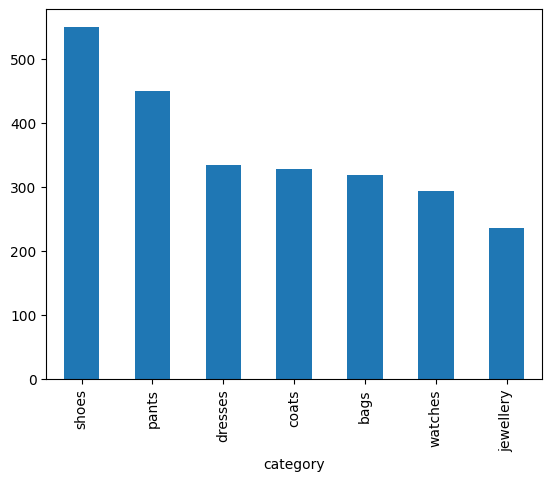

In [30]:
drop_duplicates_title["category"].value_counts().plot.bar();

In [31]:
perc = len(drop_duplicates_title["title"].apply(lambda x: str(x).casefold().strip()).unique()) / len(
    drop_duplicates_title
)
print(f"The percentage of the unique title is {round(perc*100, 1)}%")

The percentage of the unique title is 100.0%


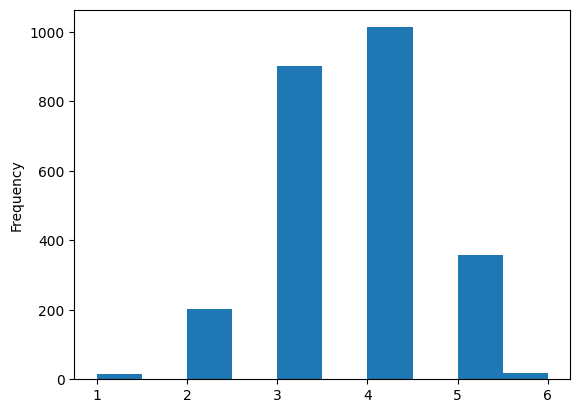

In [32]:
nwords = drop_duplicates_title["title"].apply(lambda x: len(str(x).split()))
nwords.plot.hist();

## EDA Conclusion

## Data Overview
After examining the data, I have identified several key points:

- Search vs. ProductView: When examining the name column, it appears that all categories are missing for the rows related to search. In contrast, when the rows to productviews, the corresponding categories are available as target labels.
- Sample Size: The total number of data samples is 25,909. After removing duplicate titles, the training data size is reduced to 2,508. This indicates that a significant percentage of titles are similar within the dataset. approximately 9.68% of the total data is being considered.

## Target Classes
- Class Distribution: The dataset contains seven target classes: {'bags', 'coats', 'dresses', 'jewellery', 'pants', 'shoes', 'watches'}.

- Class Balance: The distribution of these classes is quite balanced, meaning there are no significant imbalances among them.

## Label Assignment Issues
- Incorrect Labeling: Upon analyzing the relationship between categories and titles, I noticed that items in the "jewellery" category are often incorrectly labeled. Specifically, when the title includes "watch," it has been assigned to the "jewellery" category. Since there is already a "watches" category, this mislabeling adversely affects the model's learning.

## Text Preprocessing:

In [33]:
class DataProcessor:
    """
    DataProcessor handles the reading, cleaning, and saving of data from JSON log files
    for machine learning training and testing.
    """

    def __init__(self):
        self.df = None
        self.test_data = None
        self.training_data = None

    def read_json_file(self, data_path):
        try:
            logging.info("Reading JSON log file...")
            for filename in os.listdir(data_path):
                if filename.endswith(".log"):
                    filepath = os.path.join(data_path, filename)
                    self.df = pd.read_json(filepath, lines=True)
                    logging.info(f"Loaded data from {filename}")
            logging.info(f"Length of the dataframe: {len(self.df)}")
            if self.df is None or self.df.empty:
                raise ValueError("No log file found or the file is empty.")
        except Exception as e:
            logging.error(f"Error reading JSON file: {e}")
            raise

    def split_test_and_training_data(self):
        try:
            logging.info("Splitting data into test and training sets...")
            if LABEL_COLUMN_NAME not in self.df.columns:
                raise ValueError(f"{LABEL_COLUMN_NAME} not found in the DataFrame.")
            self.test_data = self.df.loc[pd.isna(self.df[LABEL_COLUMN_NAME])]
            logging.info(f"Length of the test dataframe: {len(self.test_data)}")
            self.training_data = self.df.loc[pd.notna(self.df[LABEL_COLUMN_NAME])]
            logging.info(f"Length of the training dataframe: {len(self.training_data)}")
            if self.test_data.empty:
                logging.warning("No test data available.")
            if self.training_data.empty:
                logging.warning("No training data available.")
        except Exception as e:
            logging.error(f"Error splitting data: {e}")
            raise

    def clean_labels(self):
        try:
            logging.info("Cleaning labels...")
            logging.info(
                f"Length of training dataframe before "
                f"cleaning labels: {len(self.training_data)}"
            )
            self.training_data[LABEL_COLUMN_NAME] = (
                self.training_data[LABEL_COLUMN_NAME]
                .replace("", np.nan)
                .dropna()
                .str.lower()
                .str.strip()
            )
            logging.info(
                f"Length of training dataframe after "
                f"cleaning labels: {len(self.training_data)}"
            )
        except Exception as e:
            logging.error(f"Error cleaning labels: {e}")
            raise

    def text_preprocessing(self, text: str) -> str:
        try:
            text = text.strip().casefold()
            text = re.sub(r"[^A-Za-z\s]", " ", text)
            text = re.sub(r"\s+", " ", text)
            return text.strip()
        except Exception as e:
            logging.error(f"Error during text preprocessing: {e}")
            raise

    def apply_text_preprocessing(self, data_types: list):
        try:
            for data_type in data_types:
                if data_type == "training":
                    data = self.training_data
                    column_name = TITLE
                    logging.info(
                        f"Preprocessing text in column: "
                        f"{column_name} for training data..."
                    )
                elif data_type == "test":
                    data = self.test_data
                    column_name = QUERY
                    logging.info(
                        f"Preprocessing text in column: {column_name} for test data..."
                    )
                else:
                    raise ValueError("data_type must be either 'training' or 'test'")

                data[column_name] = data[column_name].replace("", np.nan)
                data = data.dropna(subset=[column_name])
                data[FEATURE_COLUMN_NAME] = data[column_name].apply(
                    self.text_preprocessing
                )
                data[FEATURE_COLUMN_NAME] = data[FEATURE_COLUMN_NAME].replace(
                    "", np.nan
                )
                data = data.dropna(subset=[FEATURE_COLUMN_NAME])
                if data_type == "training":
                    self.training_data = data
                else:
                    self.test_data = data

        except Exception as e:
            logging.error(f"Error applying text preprocessing to {data_type} data: {e}")
            raise

    def save_dataframes(self, output_dir):
        try:
            os.makedirs(os.path.join(output_dir, "test"), exist_ok=True)
            os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
            test_data_path = os.path.join(output_dir, "test", "search_data.csv")
            train_data_path = os.path.join(
                output_dir, "train", "productview_training_data.csv"
            )
            if not self.test_data.empty:
                self.test_data.to_csv(test_data_path, index=False)
                logging.info(f"Saved test data to {test_data_path}...")
            else:
                logging.warning("No test data to save.")

            if not self.training_data.empty:
                self.training_data.to_csv(train_data_path, index=False)
                logging.info(
                    f"Saved preprocessed training data to {train_data_path}..."
                )
            else:
                logging.warning("No training data to save.")
        except Exception as e:
            logging.error(f"Error saving dataframes: {e}")
            raise


In [34]:
def preprocessing_main(data_dir: str, output_dir:str, data_types: List):
    processor = DataProcessor()
    processor.read_json_file(data_dir)
    processor.split_test_and_training_data()
    processor.clean_labels()
    processor.apply_text_preprocessing(data_types)
    processor.save_dataframes(output_dir)

In [35]:
preprocessing_main(data_dir="data/raw_data/",
                  output_dir="data/cleaned_data",
                  data_types=["training","test"])

2024-09-23 16:11:54,351 - INFO - Reading JSON log file...
2024-09-23 16:11:54,472 - INFO - Loaded data from events.log
2024-09-23 16:11:54,473 - INFO - Length of the dataframe: 25909
2024-09-23 16:11:54,474 - INFO - Splitting data into test and training sets...
2024-09-23 16:11:54,479 - INFO - Length of the test dataframe: 9949
2024-09-23 16:11:54,483 - INFO - Length of the training dataframe: 15960
2024-09-23 16:11:54,484 - INFO - Cleaning labels...
2024-09-23 16:11:54,484 - INFO - Length of training dataframe before cleaning labels: 15960
2024-09-23 16:11:54,503 - INFO - Length of training dataframe after cleaning labels: 15960
2024-09-23 16:11:54,503 - INFO - Preprocessing text in column: title for training data...
2024-09-23 16:11:54,604 - INFO - Preprocessing text in column: query for test data...
2024-09-23 16:11:54,737 - INFO - Saved test data to data/cleaned_data/test/search_data.csv...
2024-09-23 16:11:54,870 - INFO - Saved preprocessed training data to data/cleaned_data/train

## Model Training

In [36]:
def read_csv_file(data_path: str) -> pd.DataFrame:
    """
    This function read the CSV files

    """
    for filename in os.listdir(data_path):
        if filename.endswith(".csv"):
            filepath = os.path.join(data_path, filename)
            data = pd.read_csv(filepath)
    return data


def load_model_params(model_params_path: str) -> Dict[str, Any]:
    """
    The purpose of this function is to load the model parameters from the provided path.
    """
    try:
        logging.info(f'Read model params file from: "{model_params_path}".')
        with file_io.FileIO(model_params_path, "r") as f:
            model_params = yaml.safe_load(f)
        if not model_params:
            raise Exception(
                f"Failed to load the model parameters file in the"
                f'following path: "{model_params_path}", the file was not found.'
            )
        logging.info(f"The model params:\n{model_params}")
        logging.info("Model parameters loaded successfully.")
        return model_params
    except Exception as e:
        logging.error(f"Error loading model parameters: {e}")
        raise



class ModelTrainer:
    """
    Manages the training of a text classification model using DistilBERT.
    """

    def __init__(self, model_params: Dict[str, Any]):
        self.model_params = model_params
        self.tokenizer = self.get_tokenizer()
        self.label_encoder = LabelEncoder()

    def get_tokenizer(self) -> Any:
        try:
            logging.info("Download the tokenizer from Huggingface.")
            return DistilBertTokenizer.from_pretrained(
                self.model_params[TRANSFORMERS][TOKENIZER]
            )
        except Exception as e:
            logging.error(f"Error downloading tokenizer: {e}")
            raise

    def encode_labels(self, df: pd.DataFrame) -> pd.DataFrame:
        try:
            logging.info("Perform label encoding.")
            df[ENCODED_LABEL] = self.label_encoder.fit_transform(
                list(df[LABEL_COLUMN_NAME].values)
            )
            logging.info(
                f"The total number of samples: "
                f"{len(df[ENCODED_LABEL])}; classes: {len(self.label_encoder.classes_)}"
            )
            return df
        except Exception as e:
            logging.error(f"Error in label encoding: {e}")
            raise

    def split_to_train_val(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        try:
            logging.info("Perform train/validation split.")
            return train_test_split(
                df,
                test_size=self.model_params[DATA][VAL_SIZE],
                random_state=self.model_params[RANDOM_STATE],
                stratify=list(df[LABEL_COLUMN_NAME]),
            )
        except Exception as e:
            logging.error(f"Error during train/validation split: {e}")
            raise

    def tokenize_batch(self, texts: List[str]) -> Any:
        try:
            logging.info("Tokenizing batch of texts.")
            tokenized_data = []
            for i in range(0, len(texts), self.model_params[ENCODING][BATCH_SIZE]):
                batch_text = texts[i : i + self.model_params[ENCODING][BATCH_SIZE]]
                tokenized_batch = self.tokenizer(
                    batch_text,
                    max_length=self.model_params[ENCODING][MAX_LENGTH],
                    padding="max_length",
                    truncation=True,
                    return_tensors="tf",
                )["input_ids"]
                tokenized_data.append(tokenized_batch)
            return tf.concat(tokenized_data, axis=0)
        except Exception as e:
            logging.error(f"Error during tokenization: {e}")
            raise

    def build_and_train_model(
        self, train_dataset, val_dataset, callbacks: List[Any], n_steps: int
    ):
        """
        Build and train the model using TFDistilBertModel and TensorFlow's Keras API.
        """
        try:
            logging.info("Building the model.")
            bert_model = TFDistilBertModel.from_pretrained(
                self.model_params[TRANSFORMERS][MODEL]
            )

            input_ids = tf.keras.layers.Input(
                shape=(self.model_params[ENCODING][MAX_LENGTH],), dtype="int32"
            )
            bert_output = bert_model(input_ids)[0]
            cls_token = bert_output[:, 0, :]
            output = tf.keras.layers.Dense(
                len(self.label_encoder.classes_), activation="softmax"
            )(cls_token)

            model = tf.keras.models.Model(inputs=input_ids, outputs=output)

            logging.info("Compiling the model.")
            model.compile(
                optimizer=tf.keras.optimizers.Adam(
                    learning_rate=self.model_params[TRAIN][OPTIMIZATION][INIT_LR]
                ),
                loss=SparseCategoricalCrossentropy(),
                metrics=["accuracy"],
            )

            logging.info("Training the model.")
            train_start = time.time()
            model.fit(
                train_dataset,
                validation_data=val_dataset,
                steps_per_epoch=n_steps,
                epochs=self.model_params[TRAIN][EPOCHS],
                batch_size=self.model_params[TRAIN][BATCH_SIZE],
                callbacks=callbacks,
            )
            train_time_minutes = round((time.time() - train_start) / 60, 2)
            logging.info(
                f"The training has finished, took {train_time_minutes} minutes."
            )
            return model
        except Exception as e:
            logging.error(f"Error during model building or training: {e}")
            raise


class ModelEvaluator:
    """
    Evaluates a trained text classification model and calculates performance metrics.
    """

    def __init__(self, model: Any, label_encoder: LabelEncoder):
        self.model = model
        self.label_encoder = label_encoder

    def calculate_scores(
        self, x_val: Iterable[int], y_val_true: Iterable[int]
    ) -> Tuple[Any, Any, dict]:
        try:
            logging.info("Calculating the metrics.")
            prediction = self.model.predict(x_val)
            y_val_pred = tf.argmax(prediction, axis=1).numpy()
            y_val_pred = self.label_encoder.inverse_transform(y_val_pred)
            y_val_true = self.label_encoder.inverse_transform(y_val_true)
            metrics = self.get_metrics(y_val_true, y_val_pred, list(self.label_encoder.classes_))
            logging.info(f"Metrics: {metrics}")
            return y_val_pred, y_val_true, metrics
        except Exception as e:
            logging.error(f"Error during score calculation: {e}")
            raise

    def val_data(self, df_val: pd.DataFrame, y_pred: Iterable[str]):
        df_val[PREDICTED_CATEGORY] = y_pred
        return df_val
    

    def get_metrics(
        self,
        true_values: Iterable[str],
        predicted_values: Iterable[str],
        classes: List,
        round_n: int = 3,
    ) -> Dict[str, float]:
        """
        Prints classification report with accuracy.
        :param true_values: Iterable with the actual values.
        :param predicted_values: Iterable with the predicted values.
        :param round_n: The number after the decimal point.
        :return: The dictionary with the model metrics.
        """
        metrics = dict()

        acc_value = accuracy_score(true_values, predicted_values)
        metrics[ACCURACY] = round(acc_value, round_n)
        cohen = cohen_kappa_score(true_values, predicted_values)
        metrics[COHEN] = round(cohen, round_n)
        matthew = matthews_corrcoef(true_values, predicted_values)
        metrics[MATHEW] = round(matthew, round_n)

        f1_macro = f1_score(true_values, predicted_values, average="macro")
        metrics["f1-score macro"] = round(f1_macro, round_n)
        precision_macro = precision_score(
            true_values, predicted_values, average="macro"
        )
        metrics["Precision macro"] = round(precision_macro, round_n)
        recall_macro = recall_score(true_values, predicted_values, average="macro")
        metrics["Recall macro"] = round(recall_macro, round_n)

        f1_micro = f1_score(true_values, predicted_values, average="micro")
        metrics["f1-score micro"] = round(f1_micro, round_n)
        precision_micro = precision_score(
            true_values, predicted_values, average="micro"
        )
        metrics["Precision micro"] = round(precision_micro, round_n)
        recall_micro = recall_score(true_values, predicted_values, average="micro")
        metrics["Recall micro"] = round(recall_micro, round_n)

        f1_weighted = f1_score(true_values, predicted_values, average="weighted")
        metrics["f1-score weighted"] = round(f1_weighted, round_n)
        precision_weighted = precision_score(
            true_values, predicted_values, average="weighted"
        )
        metrics["Precision weighted"] = round(precision_weighted, round_n)
        recall_weighted = recall_score(
            true_values, predicted_values, average="weighted"
        )
        metrics["Recall weighted"] = round(recall_weighted, round_n)

        metrics[METRICS_FULL_REPORT] = classification_report(
            true_values, predicted_values, output_dict=True
        )
        print(classification_report(true_values, predicted_values, target_names=classes))
        return metrics


class ArtifactManager:
    """
    Handles the saving of model artifacts, including the trained model,
    label encoder, and evaluation metrics.
    """

    def __init__(self, artifacts_dir: str):
        self.artifacts_dir = artifacts_dir

    def save_artifacts(
        self,
        model: Any,
        label_encoder: LabelEncoder,
        metrics: Dict[str, float],
        df_val_df: pd.DataFrame,
    ) -> None:
        try:
            if not os.path.exists(self.artifacts_dir):
                os.makedirs(self.artifacts_dir)
            joblib.dump(
                label_encoder, os.path.join(self.artifacts_dir, LABEL_ENCODER_PKL)
            )
            metrics_dir_path = os.path.join(self.artifacts_dir, METRICS_DIR)
            os.makedirs(metrics_dir_path, exist_ok=True)
            with open(os.path.join(metrics_dir_path, METRICS_JSON), "w") as f:
                json.dump(metrics, f, ensure_ascii=False)
            model.save(self.artifacts_dir)
            df_val_df.to_csv(
                os.path.join(metrics_dir_path, "val_predicted.csv"), index=False
            )
            logging.info("The artifacts are successfully saved.")
        except Exception as e:
            logging.error(f"Error saving artifacts: {e}")
            raise


def get_callbacks(callback_params: Dict[str, Any]) -> List[Any]:

    """
    A custom function to provide the needed callbacks based on the parameters specified.
    """
    try:
        callbacks = []
        if EARLY_STOPPING in callback_params:
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor=VAL_LOSS,
                verbose=callback_params[VERBOSE],
                min_delta=callback_params[EARLY_STOPPING][MIN_DELTA],
                patience=callback_params[EARLY_STOPPING][PATIENCE],
                mode="auto",
            )
            callbacks.append(early_stopping)
        if REDUCE_ON_PLATEAU in callback_params:
            reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor=VAL_LOSS,
                verbose=callback_params[VERBOSE],
                factor=callback_params[REDUCE_ON_PLATEAU][FACTOR],
                patience=callback_params[REDUCE_ON_PLATEAU][PATIENCE],
                min_lr=callback_params[REDUCE_ON_PLATEAU][MIN_LR],
            )
            callbacks.append(reduce_on_plateau)
        logging.info(f"Callbacks: {callbacks}")
        return callbacks
    except Exception as e:
        logging.error(f"Error get_callbacks: {e}")
        raise


def transform_data_for_training(
    x_train: Iterable[int],
    y_train: Iterable[int],
    x_val: Iterable[int],
    y_val: Iterable[int],
    model_params: Dict,
) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    """
    Transforms training and validation data into TensorFlow datasets.

    This function takes training and validation input data and labels,
    creates TensorFlow datasets, and applies necessary transformations
    such as shuffling and batching for training.
    """
    train_dataset = (
        tf.data.Dataset.from_tensor_slices((x_train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(model_params[TRAIN][BATCH_SIZE])
        .prefetch(AUTO)
    )

    val_dataset = (
        tf.data.Dataset.from_tensor_slices((x_val, y_val))
        .batch(model_params[TRAIN][BATCH_SIZE])
        .cache()
        .prefetch(AUTO)
    )
    return train_dataset, val_dataset


def train_main(data_path: str, model_params_path: str, artifacts_dir: str) -> None:
    """
    Main function to train the model.

    This function loads the model parameters, reads the training data,
    encodes labels, splits the data into training and validation sets,
    tokenizes the text data, builds and trains the model, evaluates
    its performance, and saves the artifacts.
    """
    model_params = load_model_params(model_params_path)
    df = read_csv_file(data_path)
    df = df.drop_duplicates(
        subset=[FEATURE_COLUMN_NAME, LABEL_COLUMN_NAME], keep="first"
    )

    trainer = ModelTrainer(model_params)
    df_encoded = trainer.encode_labels(df)
    df_train, df_val = trainer.split_to_train_val(df_encoded)

    x_train = trainer.tokenize_batch(list(df_train[FEATURE_COLUMN_NAME]))
    x_val = trainer.tokenize_batch(list(df_val[FEATURE_COLUMN_NAME]))
    y_train = list(df_train[ENCODED_LABEL])
    y_val = list(df_val[ENCODED_LABEL])

    train_dataset, val_dataset = transform_data_for_training(
        x_train, y_train, x_val, y_val, model_params
    )

    n_steps = x_train.shape[0] // model_params[TRAIN][BATCH_SIZE]
    callbacks = get_callbacks(model_params[TRAIN][CALLBACKS])

    model = trainer.build_and_train_model(
        train_dataset, val_dataset, callbacks, n_steps
    )

    evaluator = ModelEvaluator(model, trainer.label_encoder)
    y_pred, y_true, metrics = evaluator.calculate_scores(x_val, y_val)
    df_val_pred = evaluator.val_data(df_val, y_pred)

    artifact_manager = ArtifactManager(artifacts_dir)
    artifact_manager.save_artifacts(model, trainer.label_encoder, metrics, df_val_pred)


In [37]:
train_main(data_path="data/cleaned_data/train",
           model_params_path="config/model/dev.yml",
          artifacts_dir="model_artifacts")

2024-09-23 16:11:56,545 - INFO - Read model params file from: "config/model/dev.yml".
2024-09-23 16:11:56,552 - INFO - The model params:
{'version': 0.1, 'random_state': 42, 'data': {'val_size': 0.2}, 'encoding': {'max_length': 32, 'batch_size': 32}, 'transformers': {'tokenizer': 'distilbert-base-uncased', 'model': 'distilbert-base-uncased', 'activation': 'softmax'}, 'train': {'batch_size': 32, 'epochs': 50, 'optimization': {'init_lr': 1e-05}, 'callbacks': {'verbose': True, 'early_stopping': {'min_delta': 0, 'patience': 1}, 'reduce_on_plateau': {'factor': 0.2, 'patience': 1, 'min_lr': 1e-06}}}, 'inference': {'batch_size': 32}}
2024-09-23 16:11:56,553 - INFO - Model parameters loaded successfully.
2024-09-23 16:11:56,593 - INFO - Download the tokenizer from Huggingface.
2024-09-23 16:11:56,804 - INFO - Perform label encoding.
2024-09-23 16:11:56,808 - INFO - The total number of samples: 2588; classes: 7
2024-09-23 16:11:56,809 - INFO - Perform train/validation split.
2024-09-23 16:11:56

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-09-23 16:12:02,472 - WARNING - From /home/jupyter/.local/lib/python3.10/site-packages/tensorflow/python/autograph/pyct/static_analysis/liveness.py:83: Analyzer.lamba_check (from tensorflow.python.autograph.pyct.static_analysis.liveness) is deprecated and will be removed after 2023-09-23.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2024-09-23 16:12:03,920 - INFO - Compiling the model.
2024-09-23 16:12:03,936 - INFO - Training the model.


Epoch 1/50


2024-09-23 16:12:17.249898: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55d5e03fa8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-23 16:12:17.249956: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-09-23 16:12:17.259312: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-23 16:12:17.421064: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 33s 173ms/step - loss: 1.3207 - accuracy: 0.5181 - val_loss: 0.1765 - val_accuracy: 0.9517 - lr: 1.0000e-05
Epoch 2/50
64/64 [==============================] - 7s 111ms/step - loss: 0.1542 - accuracy: 0.9326 - val_loss: 0.0809 - val_accuracy: 0.9653 - lr: 1.0000e-05
Epoch 3/50
64/64 [==============================] - 7s 116ms/step - loss: 0.0682 - accuracy: 0.9717 - val_loss: 0.0490 - val_accuracy: 0.9672 - lr: 1.0000e-05
Epoch 4/50
64/64 [==============================] - 7s 114ms/step - loss: 0.0644 - accuracy: 0.9648 - val_loss: 0.0486 - val_accuracy: 0.9768 - lr: 1.0000e-05
Epoch 5/50
64/64 [==============================] - 7s 113ms/step - loss: 0.0524 - accuracy: 0.9683 - val_loss: 0.0473 - val_accuracy: 0.9672 - lr: 1.0000e-05
Epoch 6/50
64/64 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9697
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
64/64 [==============================] - 7s 

2024-09-23 16:13:13,547 - INFO - The training has finished, took 1.16 minutes.
2024-09-23 16:13:13,548 - INFO - Calculating the metrics.


17/17 [==============================] - 2s 34ms/step


2024-09-23 16:13:15,805 - INFO - Metrics: {'Accuracy': 0.963, 'Cohen': 0.957, 'Mathew': 0.958, 'f1-score macro': 0.956, 'Precision macro': 0.958, 'Recall macro': 0.958, 'f1-score micro': 0.963, 'Precision micro': 0.963, 'Recall micro': 0.963, 'f1-score weighted': 0.963, 'Precision weighted': 0.968, 'Recall weighted': 0.963, 'full_report': {'bags': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 64.0}, 'coats': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 65.0}, 'dresses': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 67.0}, 'jewellery': {'precision': 0.7647058823529411, 'recall': 0.9454545454545454, 'f1-score': 0.8455284552845529, 'support': 55.0}, 'pants': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 90.0}, 'shoes': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 110.0}, 'watches': {'precision': 0.9444444444444444, 'recall': 0.7611940298507462, 'f1-score': 0.8429752066115702, 'support': 67.0}, 'accuracy': 0.

              precision    recall  f1-score   support

        bags       1.00      1.00      1.00        64
       coats       1.00      1.00      1.00        65
     dresses       1.00      1.00      1.00        67
   jewellery       0.76      0.95      0.85        55
       pants       1.00      1.00      1.00        90
       shoes       1.00      1.00      1.00       110
     watches       0.94      0.76      0.84        67

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.97      0.96      0.96       518



2024-09-23 16:13:17,049 - WARNING - Skipping full serialization of Keras layer <keras.layers.regularization.dropout.Dropout object at 0x7f842fcff3d0>, because it is not built.


2024-09-23 16:13:17,068 - WARNING - Skipping full serialization of Keras layer <keras.layers.regularization.dropout.Dropout object at 0x7f83cd358a00>, because it is not built.


2024-09-23 16:13:17,085 - WARNING - Skipping full serialization of Keras layer <keras.layers.regularization.dropout.Dropout object at 0x7f83ccf0a7a0>, because it is not built.


2024-09-23 16:13:17,103 - WARNING - Skipping full serialization of Keras layer <keras.layers.regularization.dropout.Dropout object at 0x7f83cdb8c6a0>, because it is not built.


2024-09-23 16:13:17,120 - WARNING - Skipping full serialization of Keras layer <keras.layers.regularization.dropout.Dropout object at 0x7f83cdb8d5a0>, because it is not built.


2024-09-23 16:13:17,138 - WARNING - Skipping full serialization of Keras layer <keras.layers.regularization.dropout.Dropout object at 0x7f83c7ddbc10>, because it is not built.
2024-09-23 16:13:38,662 - WARNING - Found untraced functions such as serving, embeddings_layer_call_fn, embeddings_layer_call_and_return_conditional_losses, transformer_layer_call_fn, transformer_layer_call_and_return_conditional_losses while saving (showing 5 of 165). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_artifacts/assets


2024-09-23 16:13:52,685 - INFO - Assets written to: model_artifacts/assets
2024-09-23 16:13:54,093 - INFO - The artifacts are successfully saved.


## False positive case Analysis (Model Evaluation)

In [38]:
df_val_eval = read_csv_file("model_artifacts/metrics")

In [39]:
df_val_eval.head(2)

,session,name,query,title,product_id,category,clean_text,encoded_label,predicted_catagory
0,cee58448531e5badbf35c172421750dae7b6dccf25e9f9...,productview,NaN,red metalic watch,223722.0,jewellery,red metalic watch,3,jewellery
1,a841ecbbe6f0c33ba9f9a156bb9a61c7496ce33c53684a...,productview,NaN,black metalic shoes,654899.0,shoes,black metalic shoes,5,shoes


In [40]:
df_val_eval.loc[df_val_eval.category!=df_val_eval.predicted_catagory]

,session,name,query,title,product_id,category,clean_text,encoded_label,predicted_catagory
69,174072b21201021ccee9dadf93be1c5893f5aa9c7fca81...,productview,NaN,white wristwatch,1582101.0,watches,white wristwatch,6,jewellery
97,ab33f365f0bc526f50aa2f7c823a5118ae7e8965447c1e...,productview,NaN,yellow leather wristwatch,6824127.0,watches,yellow leather wristwatch,6,jewellery
122,bf570a0227cb1f07f6878b2655fff4a9fe46deb671a35a...,productview,NaN,black metalic watch,3881906.0,watches,black metalic watch,6,jewellery
125,5b6f6ed37212c74bad8a3e74396d46612712f050433086...,productview,NaN,blue wool wristwatch,9265216.0,jewellery,blue wool wristwatch,3,watches
126,4fbe564f725e0ff0ca4339209b466225789e51af04b2eb...,productview,NaN,white wool wristwatch,4975172.0,watches,white wool wristwatch,6,jewellery
141,0578570a4c8bf66dc08fa9a534d65e12d3ee0dd379f643...,productview,NaN,red gold wristwatch,7057529.0,watches,red gold wristwatch,6,jewellery
160,45aa909e9f773279f17bb3e6516336154f8c6d3180eec3...,productview,NaN,yellow gold watch,6916847.0,watches,yellow gold watch,6,jewellery
185,1cc3f973ec9dcbb66cef2075b7c3cb48d06e8d91e63321...,productview,NaN,white leather watch,7447003.0,watches,white leather watch,6,jewellery
228,59c7e4e5f11b216d1975f65e350c03a1065639b90479b6...,productview,NaN,green metalic watch,3710806.0,watches,green metalic watch,6,jewellery
234,ec09f32a2d7ff540c5a8ce4e816b9ba73db082e2b4c889...,productview,NaN,blue leather wristwatch,5363480.0,watches,blue leather wristwatch,6,jewellery


In [41]:
drop_duplicates_title = productview_data.drop_duplicates(subset=["title"], keep='first') 

In [42]:
drop_duplicates_title.loc[drop_duplicates_title.category=="jewellery"]

,session,name,query,title,product_id,category
9,04887a80950be6087da8b1e0ec3b80e8478db27779ce42...,productview,NaN,beige metalic ana luisa watch,8882812.0,jewellery
17,8bb909f2e71d211b11ec82988eefe0c06669d4c9e100b9...,productview,NaN,black gold gucci wristwatch,74491.0,jewellery
18,8bb909f2e71d211b11ec82988eefe0c06669d4c9e100b9...,productview,NaN,metalic wristwatch,1244247.0,jewellery
29,7039fd0ea22577b570990052cb96e99d5fc03736cf40ad...,productview,NaN,gold watch,3354668.0,jewellery
82,2c066bd6d431d59cbdb8ccf1b240982dd0e3cdaf31e1b7...,productview,NaN,gucci wristwatch,7224256.0,jewellery
...,...,...,...,...,...,...
22304,4a780475a159420c4e4da19448ae925a51375d6dc2f8c8...,productview,NaN,beige gold armani wristwatch,6737167.0,jewellery
22799,1c541d934539736bcc751cb7c13e2cc6e5b28b9199bf4c...,productview,NaN,red metalic ana luisa wristwatch,4294033.0,jewellery
23229,e02a05763b33d385261b65d8d2511eaf728b555b32076a...,productview,NaN,blue wool armani wristwatch,1416031.0,jewellery
23952,ec6d4d38264b97d8b49a2ea2bacd1b9c90ea06e11b3564...,productview,NaN,yellow metalic gucci wristwatch,1227527.0,jewellery


In [43]:
drop_duplicates_title.loc[drop_duplicates_title.category=="watches"]

,session,name,query,title,product_id,category
13,56b9b97509d497a01c8be6cf0aaf3c53680b7e62bb112b...,productview,NaN,green leather wristwatch,6656681.0,watches
14,56b9b97509d497a01c8be6cf0aaf3c53680b7e62bb112b...,productview,NaN,Rolex watch,9023669.0,watches
15,56b9b97509d497a01c8be6cf0aaf3c53680b7e62bb112b...,productview,NaN,watch,5496752.0,watches
23,9e4d1744490531bb504471affdd3c77b7319b4199fb75f...,productview,NaN,yellow Rolex wristwatch,1496062.0,watches
41,59c7e4e5f11b216d1975f65e350c03a1065639b90479b6...,productview,NaN,green metalic watch,3710806.0,watches
...,...,...,...,...,...,...
23781,f6ef34908c43be2f86c55d756687da24888f477b2db594...,productview,NaN,red leather casio wristwatch,6898066.0,watches
23962,2b506eec5ff07d70fc0373fbd6cd75b0f5cd2b4ce093ac...,productview,NaN,white wool prada wristwatch,7304203.0,watches
24081,89564743aeeb168980ecfd0f0b3dd596e0998827cd50ae...,productview,NaN,green leather prada wristwatch,2621148.0,watches
24324,b6c31e43038534fef7e072d1a26c98472ccdd76f674676...,productview,NaN,green gold casio watch,7874926.0,watches


In [44]:
len(drop_duplicates_title)

2508

As observed in the training data and false positive data, within the product_view column, specifically in the title for "watches" and "jewellery" removing duplicate features reveals that out of the total 2508 samples, 294 are assigned to "watch" and 235 to "jewellery." However, the "jewellery" label has been incorrectly assigned in all the cases, as the titles describe watches. This mislabeling disrupts the model’s ability to differentiate effectively between watches and jewellery.

As a result, the model is incorrectly predicting items under the "jewellery" category. To resolve this, we need to correct the labels and retrain the model.

Consequently, we see in the classification report that the model has lower precision but higher recall for the "jewellery" label.

## Inference

In [45]:
class InferenceModel:
    """
    Class to handle the loading of the model, label encoder, and making predictions.

    """

    def __init__(self, model_path: str, model_params_path: str):
        try:
            self.model_params = load_model_params(model_params_path)
            self.model = self.load_model(model_path)
            self.label_encoder = self.load_label_encoder(
                f"{model_path}/{LABEL_ENCODER_PKL}"
            )
        except Exception as e:
            logging.error(f"Error initializing InferenceModel: {e}")
            raise

    def load_model(self, model_path: str) -> Any:
        """Loads the model from the given path and returns it."""
        logging.info(f'Loading the Model... The path: "{model_path}"')
        try:
            model = tf.saved_model.load(model_path)
            model = self.build_model_from_pb(model)
            if not model:
                raise Exception("Failed to load the model")
            logging.info("Model was loaded successfully.")
            return model
        except Exception as e:
            logging.error(f"Error loading model from {model_path}: {e}")
            raise

    def build_model_from_pb(self, pb_model: Any) -> Any:
        """Builds and returns a Keras model from a TensorFlow Hub protobuf model."""
        try:
            input_ids_layer = tf.keras.layers.Input(
                shape=(self.model_params[ENCODING][MAX_LENGTH],),
                name="input_word",
                dtype="int32",
            )
            keras_layer = hub.KerasLayer(pb_model, trainable=False)(input_ids_layer)
            model = tf.keras.Model([input_ids_layer], keras_layer)
            return model
        except Exception as e:
            logging.error(f"Error building model from protobuf: {e}")
            raise

    def load_label_encoder(self, label_encoder_path: str) -> LabelEncoder:
        """Loads the label encoder from the specified file path."""
        logging.info(f'Loading the Label Encoder... The path: "{label_encoder_path}"')
        try:
            with file_io.FileIO(label_encoder_path, mode="rb") as encoder_file:
                label_encoder = joblib.load(encoder_file)
            if not label_encoder:
                raise Exception("Failed to load the Label Encoder")
            logging.info("Label Encoder was loaded successfully.")
            return label_encoder
        except Exception as e:
            logging.error(f"Error loading label encoder from {label_encoder_path}: {e}")
            raise

    def predict(self, inputs: tf.data.Dataset):
        """Makes predictions on the provided dataset and returns transformed categories
        and probability scores."""
        try:
            prediction = self.model.predict(
                inputs, batch_size=self.model_params[INFERENCE][BATCH_SIZE]
            )
            prob_scores = np.max(prediction, axis=1)
            prediction_transform = tf.argmax(prediction, axis=1).numpy()
            transform_cat = self.label_encoder.inverse_transform(prediction_transform)
            return transform_cat, prob_scores
        except Exception as e:
            logging.error(f"Error during prediction: {e}")
            raise


class CSVProcessor:
    """
    Class to process CSV files for inference.
    """

    def __init__(self, inference_model: InferenceModel, trainer: ModelTrainer):
        self.inference_model = inference_model
        self.trainer = trainer

    def process_csv(self, file_path: str, prediction_dir: str) -> None:
        """Processes the given CSV file and saves predictions to the specified
        directory."""
        try:
            df = read_csv_file(file_path)
            x_train = self.trainer.tokenize_batch(list(df[FEATURE_COLUMN_NAME]))
            tf_dataset = tf.data.Dataset.from_tensor_slices(x_train)
            tf_dataset = tf_dataset.batch(
                self.inference_model.model_params[INFERENCE][BATCH_SIZE]
            )
            tf_dataset = tf_dataset.prefetch(tf.data.AUTOTUNE)

            predictions, prob_scores = self.inference_model.predict(tf_dataset)

            df[PREDICTED_CATEGORY] = predictions
            df[PROB_SCORES] = prob_scores

            file_path = os.path.join(
                prediction_dir, "cleaned_data", "test", FILE_NAME_PREFIX + ".csv"
            )
            df.to_csv(file_path, index=False)
        except FileNotFoundError as e:
            logging.error(f"File not found: {e}")
            raise
        except Exception as e:
            logging.error(f"Error processing CSV: {e}")
            raise


class InferenceCLI:
    """
    Command-line interface for running inference on CSV files or raw strings.
    """

    def __init__(self, model_path: str, model_params_path: str):
        try:
            self.inference_model = InferenceModel(model_path, model_params_path)
            self.trainer = ModelTrainer(self.inference_model.model_params)
        except Exception as e:
            logging.error(f"Error initializing InferenceCLI: {e}")
            raise

    def run_csv_inference(self, csv_path: str, prediction_dir: str):
        """Runs inference on the specified CSV file and saves predictions
        to the given directory."""
        try:
            processor = CSVProcessor(self.inference_model, self.trainer)
            processor.process_csv(csv_path, prediction_dir)
        except Exception as e:
            logging.error(f"Error running CSV inference: {e}")
            raise

    def run_string_inference(self, input_string: str):
        """Runs inference on the provided string and returns the prediction
        and probability score."""
        try:
            tokens = self.trainer.tokenize_batch([input_string])
            tf_dataset = (
                tf.data.Dataset.from_tensor_slices(tokens)
                .batch(1)
                .prefetch(tf.data.AUTOTUNE)
            )
            prediction, prob_score = self.inference_model.predict(tf_dataset)
            return prediction[0], prob_score[0]
        except Exception as e:
            logging.error(f"Error during string inference: {e}")
            raise


In [46]:
cli = InferenceCLI("model_artifacts", "config/model/dev.yml")
cli.run_csv_inference("data/cleaned_data/test", "data")

2024-09-23 16:13:54,257 - INFO - Read model params file from: "config/model/dev.yml".
2024-09-23 16:13:54,263 - INFO - The model params:
{'version': 0.1, 'random_state': 42, 'data': {'val_size': 0.2}, 'encoding': {'max_length': 32, 'batch_size': 32}, 'transformers': {'tokenizer': 'distilbert-base-uncased', 'model': 'distilbert-base-uncased', 'activation': 'softmax'}, 'train': {'batch_size': 32, 'epochs': 50, 'optimization': {'init_lr': 1e-05}, 'callbacks': {'verbose': True, 'early_stopping': {'min_delta': 0, 'patience': 1}, 'reduce_on_plateau': {'factor': 0.2, 'patience': 1, 'min_lr': 1e-06}}}, 'inference': {'batch_size': 32}}
2024-09-23 16:13:54,264 - INFO - Model parameters loaded successfully.
2024-09-23 16:13:54,265 - INFO - Loading the Model... The path: "model_artifacts"
2024-09-23 16:14:04,845 - INFO - Model was loaded successfully.
2024-09-23 16:14:04,846 - INFO - Loading the Label Encoder... The path: "model_artifacts/label_encoder.pkl"
2024-09-23 16:14:04,848 - INFO - Label E

311/311 [==============================] - 11s 35ms/step


In [47]:
search_query = "red watch"

prediction, prob_score = cli.run_string_inference(search_query)
print(f"Prediction: {prediction}, Probability: {prob_score}")

2024-09-23 16:14:18,879 - INFO - Tokenizing batch of texts.


1/1 [==============================] - 0s 18ms/step
Prediction: jewellery, Probability: 0.5082703828811646
